In [1]:
from utils.binaries import *
from utils.plotting import *

import polars as pl

11:46:31 (  +11.9s) [INFO   ] -- import logging
11:46:32 (  +130ms) [INFO   ] -- import numpy as np
11:46:32 (    +9ms) [INFO   ] -- import uncertainties
11:46:32 (  +524ms) [INFO   ] -- import pandas as pd
11:46:32 (    +2ms) [WARNING] -- pandas support to be dropped at some point!
11:46:32 (    +2ms) [INFO   ] -- import binaries.tools as tools
11:46:32 (  +350ms) [INFO   ] -- import matplotlib.pyplot as plt
11:46:33 (  +456ms) [INFO   ] -- import seaborn as so
11:46:33 (    +2ms) [INFO   ] -- import plotting.tools as plot
11:46:33 (    +7ms) [DEBUG  ] -- font size set to 9.5
11:46:33 (    +1ms) [DEBUG  ] -- label size set to 13.0
11:46:33 (    +0ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
11:46:33 (    +1ms) [DEBUG  ] -- markersize set to 2.0
11:46:33 (    +0ms) [DEBUG  ] -- usetex set to False


In [2]:
# T3 histo files
t3_histos = pl.read_csv('/cr/data01/filip/Data/muonAcquisition/T3events/night/t3_histos.wcd',
                        has_header=False,
                        new_columns=['id', 't', 'vem', 'iPMT'],
                        separator=' ')

t3_histos = t3_histos.with_columns(
    histo=pl.concat_list(pl.exclude('id', 't', 'vem', 'iPMT'))
).select('id', 't', 'vem', 'iPMT', 'histo')

t3_histos

id,t,vem,iPMT,histo
i64,i64,f64,i64,list[i64]
1840,1398069000,136.1,1,"[173, 751, … 61]"
1840,1398069000,2605.2,2,"[248, 2070, … 1]"
1840,1398069000,225.08,3,"[395, 1783, … 17]"
1823,1398069011,145.5,1,"[301, 2509, … 53]"
1823,1398069011,2418.1,2,"[441, 2687, … 53]"
…,…,…,…,…
1844,1398077151,2855.5,2,"[6685, 61984, … 0]"
1844,1398077151,253.5,3,"[761, 7111, … 20]"
659,1398077167,155.4,1,"[603, 6417, … 41]"


In [3]:
# muonAcq histos

import os

def read_file(path):

    path = f'/cr/data01/filip/Data/muonAcquisition/night/' + path
    coinc_hist = lambda x, pmt: [int(e.split(' ')[pmt]) for e in x]
    peak_histo = []

    with open(path, 'r') as source:
        
        is_peak_histogram = False
        for line in source.readlines():
            line = line.strip()

            if line.startswith('Offset'):
                baseline = [int(n) for n in line.split(' ')[1:-1]]

            if line == 'Peak': 
                is_peak_histogram = True
                continue
            elif line == 'Charge':
                is_peak_histogram = False

            if is_peak_histogram:
                peak_histo.append(line)

        peak_histo1 = np.array(coinc_hist(peak_histo, 3))
        peak_histo2 = np.array(coinc_hist(peak_histo, 4))
        peak_histo3 = np.array(coinc_hist(peak_histo, 5))

    return peak_histo1, peak_histo2, peak_histo3, baseline


peak1 = {x : [] for x in ['659', '1840', '1823', '660', '643', '1839', '1844', '1845']}
peak2 = {x : [] for x in ['659', '1840', '1823', '660', '643', '1839', '1844', '1845']}
peak3 = {x : [] for x in ['659', '1840', '1823', '660', '643', '1839', '1844', '1845']}
offsets = {x : [] for x in ['659', '1840', '1823', '660', '643', '1839', '1844', '1845']}
for i, file in enumerate(os.listdir(f'/cr/data01/filip/Data/muonAcquisition/night/')):

    # try:
    #     _ = read_file(file)
    # except ValueError as e:
    #     print(file, e)

    timestamp, station = file.split('_')
    p1, p2, p3, baseline = read_file(file)
    
    peak1[station].append(p1)
    peak2[station].append(p2)
    peak3[station].append(p3)
    
    # peak_histos[station].append(peak_hist)
    # all_histos[station].append(all_hist)
    # offsets[station].append(offset)

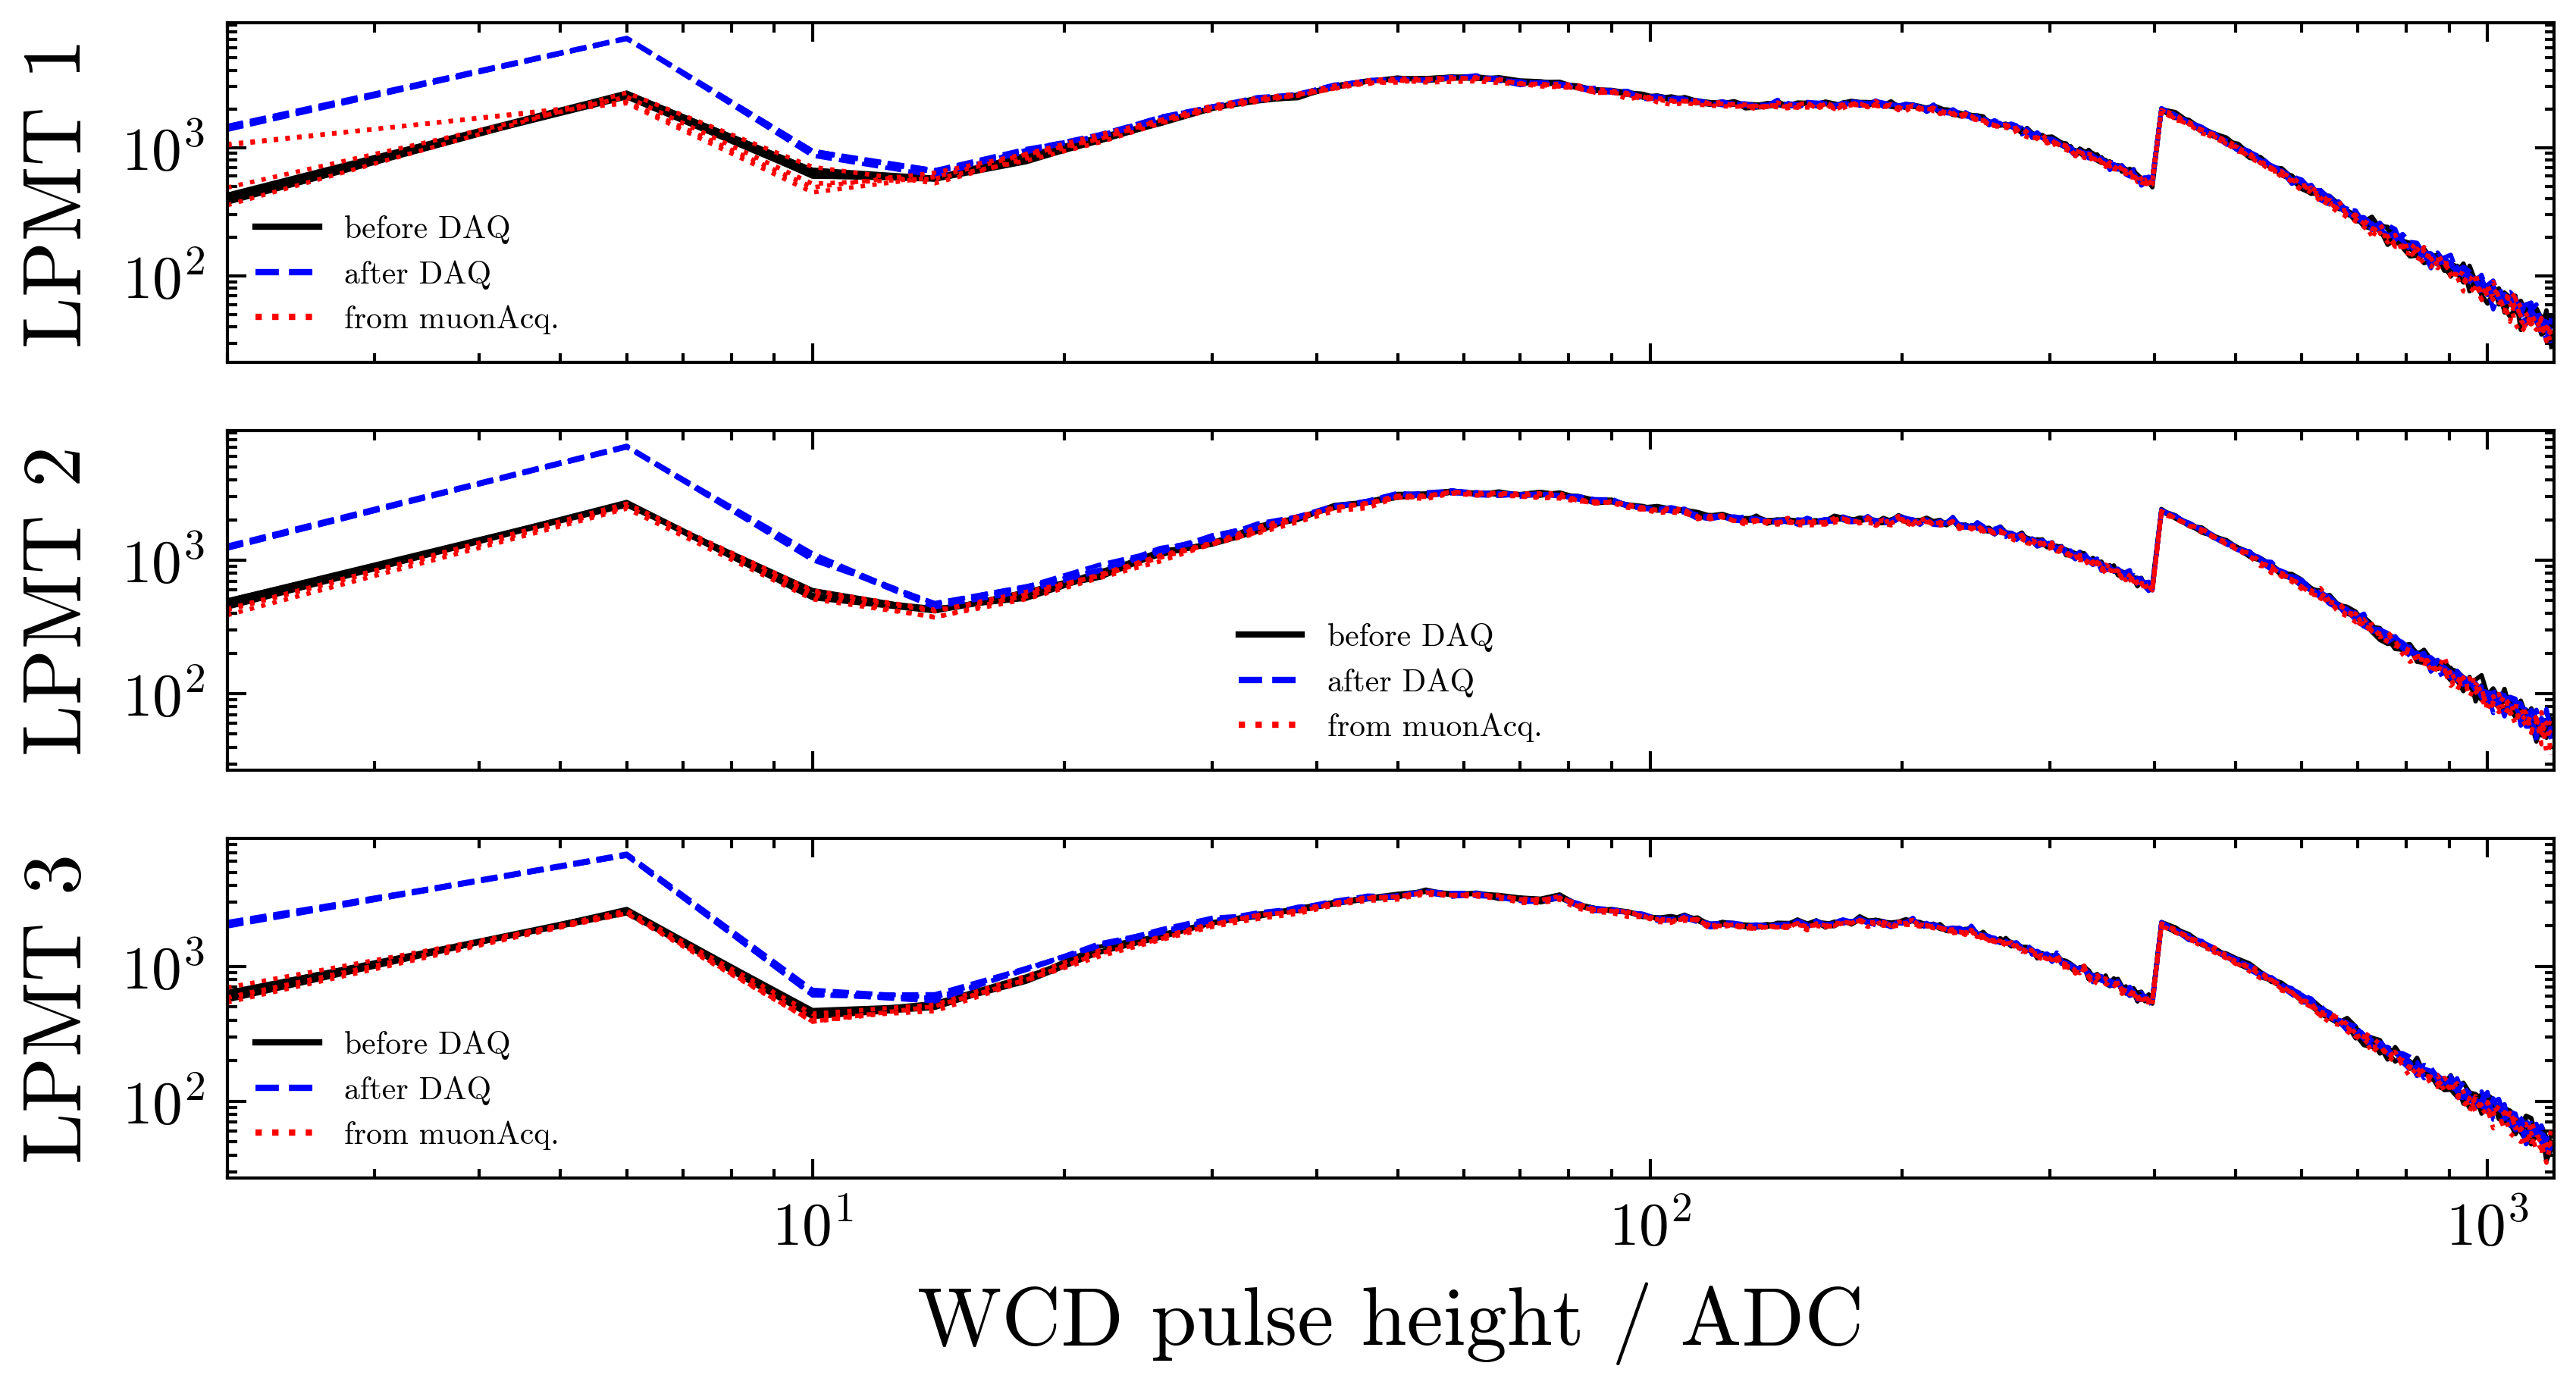

In [4]:
WCD_PEAK_HISTO_BINNING = np.array([4*k for k in range(100)] + [400 + 16*k for k in range(51)])
WCD_HISTO_BIN_CENTERS = 0.5 * (WCD_PEAK_HISTO_BINNING[1:] + WCD_PEAK_HISTO_BINNING[:-1])

id = 1845
linewidth = 0.7

fig, axes = plt.subplots(3, 1, sharex=True)
base_histo = t3_histos[0]['histo'].to_numpy()[0]
for i, event in enumerate(t3_histos.iter_rows()):
    if i == 0: continue
    if event[0] != id: continue

    color = 'blue' if event[1] > 1398070000 else 'k'
    
    # axes[event[3] - 1].axvline(event[2], c='gray', ls='--', lw=0.3)
    axes[event[3] - 1].plot(WCD_HISTO_BIN_CENTERS, np.array(event[4]), c=color, lw=linewidth, ls='solid' if color=='k' else '--')

for station in list(peak1.keys()):
    if station != str(id): continue

    peak1_histos, peak2_histos, peak3_histos = peak1[station], peak2[station], peak3[station]

    for p1, p2, p3 in zip(peak1_histos, peak2_histos, peak3_histos):
        axes[0].plot(WCD_HISTO_BIN_CENTERS, p1, c='r', lw=linewidth, ls=':')
        axes[1].plot(WCD_HISTO_BIN_CENTERS, p2, c='r', lw=linewidth, ls=':')
        axes[2].plot(WCD_HISTO_BIN_CENTERS, p3, c='r', lw=linewidth, ls=':')

for ax in axes:
    ax.plot([],[],label='before DAQ', c='k', ls='solid')
    ax.plot([],[],label='after DAQ', c='b', ls='--')
    ax.plot([],[],label='from muonAcq.', c='r', ls=':')

    legend = ax.legend(fontsize=5)

axes[0].set_yscale('log')
axes[0].set_ylabel('LPMT 1')
axes[1].set_yscale('log')
axes[1].set_ylabel('LPMT 2')
axes[2].set_yscale('log')
axes[2].set_ylabel('LPMT 3')
axes[2].set_xlabel('WCD pulse height / ADC')
axes[2].set_xlim(2, 1200)
axes[2].set_xscale('log')